# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

For this assignment, I will use reinforcement learning to solve the [Towers of Hanoi](https://en.wikipedia.org/wiki/Tower_of_Hanoi) puzzle.  

Steps required to do this include the following:

  - Represent the state, and use it as a tuple as a key to the Q dictionary.
  - Make sure only valid moves are tried from each state.
  - Assign reinforcement of $1$ to each move unless it is a move to the goal state, for which the reinforcement is $0$.  This represents the goal of finding the shortest path to the goal.

Make a plot of the number of steps required to reach the goal for each
trial.  Each trial starts from the same initial state.  Decay epsilon
as in the Tic-Tac-Toe code.

## Requirements

In order to represent the state of the puzzle, I will keep track of which disks are on which pegs with a list of integers per peg. 

For example, the starting state with all disks being on the left peg would be `[[1, 2, 3], [], []]`.  After moving disk 1 to peg 2, we have `[[2, 3], [1], []]`.

To represent that move we just made, we can use a list of two peg numbers, like `[1, 2]`, representing a move of the top disk on peg 1 to peg 2.

# Required Functions

Herer are the functions I will use within the main function:

   - `printState(state)`: prints the state in the form shown below
   - `validMoves(state)`: returns list of moves that are valid from `state`
   - `makeMove(state, move)`: returns new (copy of) state after move has been applied.
   - `trainQ(nRepetitions, learningRate, epsilonDecayFactor)`: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of steps to reach goal for each repetition.
   - `testQ(Q, maxSteps)`: without updating Q, use Q to find greedy action each step until goal is found. Return path of states.
   - `stateMoveTuple(state, move)`: returns tuple of state and move. This is useful for converting state and move to a key to be used for the Q dictionary.

In [242]:
import copy as cp

def printState(state):
    printedLists = cp.deepcopy(state)
    for list in printedLists:
        spaces = [' '] * (3 - len(list))
        list[0:0] = spaces
    
    print("{} {} {}".format(printedLists[0][0], printedLists[1][0], printedLists[2][0]))
    print("{} {} {}".format(printedLists[0][1], printedLists[1][1], printedLists[2][1]))
    print("{} {} {}".format(printedLists[0][2], printedLists[1][2], printedLists[2][2]))
    print('------')

In [243]:
state = [[1, 2, 3], [], []]
printState(state)

1    
2    
3    
------


In [244]:
def validMoves(state):
    """ given the state of columns, generate possible next
    states and return list of moves [fromColumn, toColumn]"""
    
    actions = []
    for (idx, column) in enumerate(state):
        if len(column): # tower has disk
            disk = column[0]
            if (len(state) > idx + 1): # there is a column to the right
                if (len(state[idx+1]) == 0 or state[idx+1][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx+2])
            
            if (idx > 0): # there is a column to the left
                if (len(state[idx-1]) == 0 or state[idx-1][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx])
                    
            
            if (idx > 1): # there is a column 2 to the left
                if (len(state[idx-2]) == 0 or state[idx-2][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx-1])
                    
            if (len(state) > idx + 2): # there is a column 2 to the right
                if (len(state[idx+2]) == 0 or state[idx+2][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx+3])
    
    return actions

In [245]:
validMoves([[1, 2, 3], [], []])

[[1, 2], [1, 3]]

In [246]:
validMoves([[2, 3], [], [1]])

[[1, 2], [3, 2], [3, 1]]

In [247]:
validMoves([[3], [2], [1]])

[[2, 1], [3, 2], [3, 1]]

In [248]:
def stateMoveTuple(state, move):
    """ takes in state and move and converts
    the three sub lists in state to tuples and move to tuple
    and returns all nested in a parent tuple"""
    return (tuple(state[0]), tuple(state[1]), tuple(state[2]), tuple(move))

In [249]:
move =[1, 2]

stateMoveTuple(state, move)

((1, 2, 3), (), (), (1, 2))

In [250]:
import copy as cp

def makeMove(state, move):
    """ takes in the state of towers and the move to make in the form of
    [fromTower, toTower] and moves the top disk of fromTower to the top of
    toTower"""
    
    nextState = cp.deepcopy(state)
    startPeg = move[0] - 1
    endPeg = move[1] - 1
    
    nextState[endPeg].insert(0, nextState[startPeg][0])
    del nextState[startPeg][0]
    return nextState

In [251]:
state
newstate = makeMove(state, move)
newstate

[[2, 3], [1], []]

In [252]:
printState(newstate)

     
2    
3 1  
------


### Q functions

Now time to implement Q, a function that will randomly guess a move and learn from the results. As the decayRate gets closer to the desired value, Q will stop guessing and take greedy actions more and more.

I will be representing Q as a dictionary in python that consists of a key tuple (state, move) and a value of the state

In [253]:
Q = {}  # empty table
Q[stateMoveTuple(state, move)] = 0
Q

{((1, 2, 3), (), (), (1, 2)): 0}

In [254]:
Q.get(stateMoveTuple(state, move), 0)

0

`get` handles undefined moves with a default:

In [255]:
Q.get(stateMoveTuple([[3, 2, 1], [8], [2]], (2, 2)), 42) # 42 is returned because the key doesn't exist

42

This is a gameOver function that will return true if we hit the end state

In [256]:
def gameOver(state):
    return state == [[], [], [1, 2, 3]]

In [257]:
gameOver([[1], [], [2, 3]])

False

In [258]:
gameOver([[], [], [1, 2, 3]])

True

another helper function is `epsilonGreedy` which is going to choose whether to make a random move based on the epsilon value

In [259]:
import random
import numpy as np

def epsilonGreedy(epsilon, Q, state, validMovesF):
    validMoves = validMovesF(state)
    if np.random.uniform() < epsilon:
        # Random Move
        return random.choice(validMoves)
    else:
        # Greedy Move
        Qs = np.array([Q.get(stateMoveTuple(state ,m), -1) for m in validMoves]) 
        return validMoves[ np.argmin(Qs) ]

In [260]:
epsilonGreedy(0.8, Q, state, validMoves)

[1, 3]

## Plot

This function will plot some values for us on a graph. It will get called by functions to show the results in a more pleasing way.

In [261]:
import matplotlib.pyplot as plt
%matplotlib inline

In [262]:
def plotOutcomes(steps, epsilons):
    plt.plot(steps, epsilons)
    plt.xlabel('epsilon')
    plt.ylabel('Steps to goal')
    plt.gca().invert_xaxis()

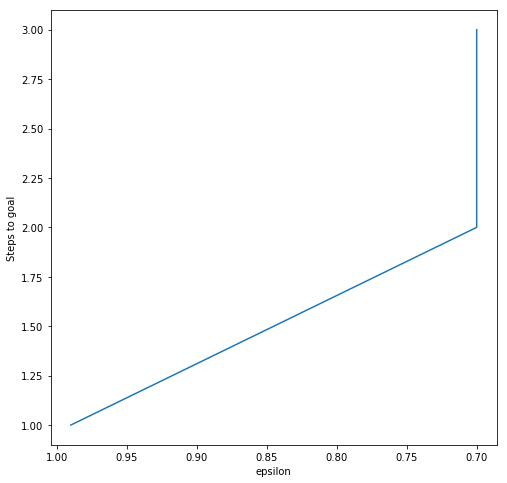

In [263]:
plt.figure(figsize=(8,8))
plotOutcomes([0.99, 0.7, 0.7],[1, 2, 3])



## trainQ

`trainQ` will handle building up the dictionary of Q values. It will run a given amount of times (solve the puzzle over and over that many times). 

Each time through it will use the same Q dictionary that has been getting updated. The dictionary values will be updated by the `learningRate`, so states that lead to a result fewer times will get a higher value. This means that the `epsilonGreedy` function will start to take moves determined to lead to an answer based of this value. It will choose those solutions more and more each playthrough. 

So, playthrough 1 will have many random guesses and take awhile to find out what the answer is, but the final playthrough will use the greedy result more and check for the best path based off the previous playthrough Q values.

In [264]:
import numpy as np
import copy as cp

def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF):
    """ train up a Q table of moves, returns Q and the table of steps to goal from states
    nRepetitions = number of times to run the test
    learningRate = rho, the rate at which to adjust previous values based on next value
    epsilonDecayFactor = the rate to decay guesses vs. greedy moves
    validMovesF = a function to return value possible moves to be made
    makeMove = a function to apply the move to the state"""
    
    graphics = True
    Q = {}
    epsilon = 1.0
    # track how many steps it took on each repetition, this hopefully gets lower as time goes on
    stepsToGoal = np.zeros(nRepetitions)
    epsilons = np.zeros(nRepetitions)
    
    if graphics == True:
        plt.figure(figsize=(8,8))
    
    for rep in range(nRepetitions):
        state = [[1, 2, 3], [], []] # starting state
        done = False
        epsilon *= epsilonDecayFactor
        steps = 0 # start at zero steps taken
        while not done: # go until we find the solution
            steps += 1
            move = epsilonGreedy(epsilon, Q, state, validMovesF) # find a moves, prune out moves that would make a state we've seen?
            stateNew = makeMoveF(cp.deepcopy(state), move)
            
            if (stateMoveTuple(state, move)) not in Q:
                Q[stateMoveTuple(state, move)] = 0 # add an initial value for the state
            
            if gameOver(stateNew):
                Q[stateMoveTuple(state, move)] = 0 # set winning state to 0
                stepsToGoal[rep] = steps # how many steps it took in this playthrough to reach the goal
                epsilons[rep] = epsilon
                    
                done = True
                
            if steps > 1: # update learned values after first step
                # based on the new value we learned, update the old value with the learningRate adjustment
                Q[stateMoveTuple(stateOld, moveOld)] += learningRate * (1 + Q[stateMoveTuple(state, move)] -
                                                                       Q[stateMoveTuple(stateOld, moveOld)])
            
            stateOld, moveOld = state, move # save old state/move for updating learned values
            state = stateNew # set new state for next iteration
            
    if graphics == True:
        plotOutcomes(epsilons,stepsToGoal)
    
    return (Q, stepsToGoal)
    

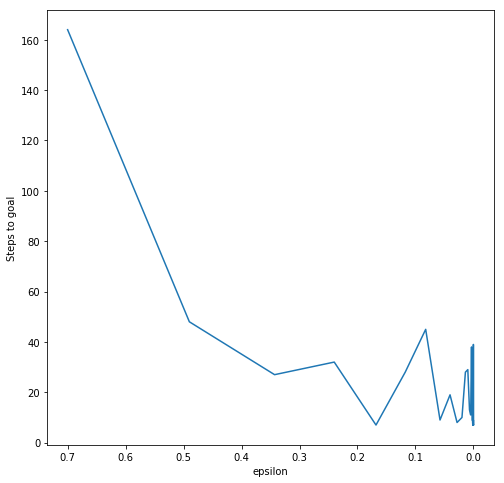

In [265]:
Q, stepsToGoal = trainQ(50, 0.5, 0.7, validMoves, makeMove)

In [266]:
stepsToGoal

array([ 164.,   48.,   27.,   32.,    7.,   28.,   45.,    9.,   19.,
          8.,   10.,   28.,   29.,   13.,   11.,   38.,    9.,    9.,
          7.,   23.,    8.,   11.,    7.,    7.,    9.,    7.,   39.,
          7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,    7.,
          7.,    7.,    7.,    7.,    7.])

Above, you can see that steps to goal eventually solves the puzzle much faster than it does in the first attempt

What does Q turn out to be? Well, it's a list of states and steps (possibly not all) and a value. Closer to one is better. 

In [267]:
Q.get(((1,), (), (2, 3), (1, 3))) # this is a win it gets a 0!

0

In [268]:
Q.get(((3,), (1,), (2,), (3, 1))) # this move doesn't lead to a win as fast, further from 0

5.504915475845337

## Test

Now we have a dictionary of Q values, which shows which state/move combinations have the best chance of producing a win. We can test this by always picking the greedy option and seeing if the puzzle is solved efficiently!

In [269]:
def testQ(Q, maxSteps, validMovesF, makeMoveF):
    """ takes a Q setup and maxSteps to try, calls the validMoves function and 
    checks results against the Q value for that state/move pair. Then executes
    the best move with makeMove. Adds each new state to a path that gets returned"""
    steps = 0
    state = [[1, 2, 3], [], []]
    path = [state]
    while steps < maxSteps:
        steps += 1
        validMoves = validMovesF(state)
        Qs = np.array([Q.get(stateMoveTuple(state, m), 0) for m in validMoves]) 
        move = validMoves[ np.argmin(Qs) ]
        stateNew = makeMoveF(cp.deepcopy(state), move)
        path += [stateNew]
        
        if gameOver(stateNew):
            break
            
        state = stateNew
    
    return path
        

In [270]:
path = testQ(Q, 20, validMoves, makeMove)

In [271]:
path

[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [272]:
for s in path:
    printState(s)
    print()

1    
2    
3    
------

     
2    
3   1
------

     
     
3 2 1
------

     
  1  
3 2  
------

     
  1  
  2 3
------

     
     
1 2 3
------

     
    2
1   3
------

    1
    2
    3
------



Winner! The Q function learned a fast way to solve the puzzle.

My reinforcement used a `argmin` with a reinforcement of positive $1$ instead of $-1$, I'm not sure why I couldn't get it working right the other way around.

## 4 disks

Let's try this again with four disks!

In [273]:
import copy as cp

def printState_4disk(state):
    printedLists = cp.deepcopy(state)
    for list in printedLists:
        spaces = [' '] * (4 - len(list))
        list[0:0] = spaces
    
    print("{} {} {}".format(printedLists[0][0], printedLists[1][0], printedLists[2][0]))
    print("{} {} {}".format(printedLists[0][1], printedLists[1][1], printedLists[2][1]))
    print("{} {} {}".format(printedLists[0][2], printedLists[1][2], printedLists[2][2]))
    print("{} {} {}".format(printedLists[0][3], printedLists[1][3], printedLists[2][3]))
    print('------')

In [274]:
printState_4disk([[1, 2, 3, 4], [], []])

1    
2    
3    
4    
------


In [275]:
printState_4disk([[1, 2, 3], [4], []])

     
1    
2    
3 4  
------


In [276]:
def validMoves_4disk(state):
    """ given the state of columns, generate possible next
    states and return list of moves [fromColumn, toColumn]"""
    
    actions = []
    for (idx, column) in enumerate(state):
        if len(column): # tower has disk
            disk = column[0]
            if (len(state) > idx + 1): # there is a column to the right
                if (len(state[idx+1]) == 0 or state[idx+1][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx+2])
            
            if (idx > 0): # here is a column to the left
                if (len(state[idx-1]) == 0 or state[idx-1][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx])
                    
            
            if (idx > 1): # there is a column 2 to the left
                if (len(state[idx-2]) == 0 or state[idx-2][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx-1])
                    
            if (len(state) > idx + 2): # there is a column 2 to the right
                if (len(state[idx+2]) == 0 or state[idx+2][0] > disk): # column is empty OR has larger disk
                    actions.append([idx+1, idx+3])
    
    return actions

In [277]:
validMoves_4disk([[1, 2, 3, 4], [], []])

[[1, 2], [1, 3]]

In [278]:
validMoves_4disk([[4], [1, 3], [2]])

[[2, 3], [2, 1], [3, 1]]

In [279]:
validMoves_4disk([[4], [], [1, 2, 3]])

[[1, 2], [3, 2], [3, 1]]

In [280]:
import copy as cp

def makeMove_4disk(state, move):
    """ takes in the state of towers and the move to make in the form of
    [fromTower, toTower] and moves the top disk of fromTower to the top of
    toTower"""
    
    nextState = cp.deepcopy(state)
    startPeg = move[0] - 1
    endPeg = move[1] - 1
    
    nextState[endPeg].insert(0, nextState[startPeg][0])
    del nextState[startPeg][0]
    return nextState

In [281]:
makeMove_4disk([[1, 2, 3, 4], [], []], [1, 2])

[[2, 3, 4], [1], []]

In [282]:
def gameOver_4disk(state):
    return state == [[], [], [1, 2, 3, 4]]

Great. We now have a set of helper functions for finding out the path to a 4-disk solution. Let's see how this changes Q.

In [283]:
import numpy as np
import copy as cp

def trainQ_4disk(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF):
    """ train up a Q table of moves, returns Q and the table of steps to goal from states
    nRepetitions = number of times to run the test
    learningRate = rho, the rate at which to adjust previous values based on next value
    epsilonDecayFactor = the rate to decay guesses vs. greedy moves
    validMovesF = a function to return value possible moves to be made
    makeMove = a function to apply the move to the state"""
    
    graphics = True
    Q = {}
    epsilon = 1.0
    # track how many steps it took on each repetition, this hopefully gets lower as time goes on
    stepsToGoal = np.zeros(nRepetitions)
    epsilons = np.zeros(nRepetitions)
    if graphics == True:
        plt.figure(figsize=(8,8))
        
    for rep in range(nRepetitions):
        state = [[1, 2, 3, 4], [], []] # starting state
        done = False
        epsilon *= epsilonDecayFactor
        steps = 0 # start at zero steps taken
        while not done: # go until we find the solution
            steps += 1
            move = epsilonGreedy(epsilon, Q, state, validMovesF) # find a moves, prune out moves that would make a state we've seen?
            stateNew = makeMoveF(cp.deepcopy(state), move)
            
            if (stateMoveTuple(state, move)) not in Q:
                Q[stateMoveTuple(state, move)] = 0 # add an initial value for the state
            
            if gameOver_4disk(stateNew):
                Q[stateMoveTuple(state, move)] = 0 # set winning state to 0
                stepsToGoal[rep] = steps # how many steps it took in this playthrough to reach the goal
                epsilons[rep] = epsilon
                done = True
                
            if steps > 1: # update learned values after first step
                # based on the new value we learned, update the old value with the learningRate adjustment
                Q[stateMoveTuple(stateOld, moveOld)] += learningRate * (1 + Q[stateMoveTuple(state, move)] -
                                                                       Q[stateMoveTuple(stateOld, moveOld)])
            
            stateOld, moveOld = state, move # save old state/move for updating learned values
            state = stateNew # set new state for next iteration
    
    if graphics == True:
        plotOutcomes(epsilons,stepsToGoal)
    return (Q, stepsToGoal)

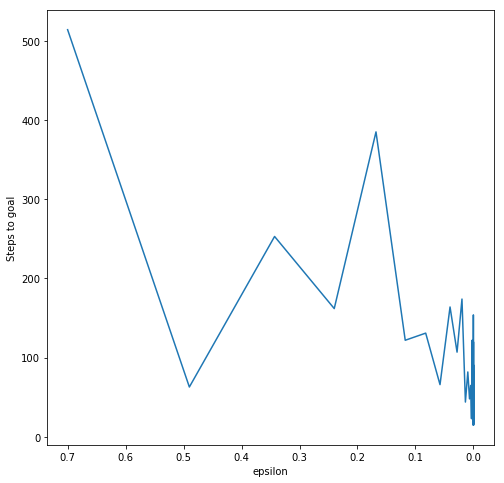

In [284]:
Q, stepsToGoal = trainQ_4disk(50, 0.5, 0.7, validMoves_4disk, makeMove_4disk)

In [285]:
stepsToGoal

array([ 514.,   63.,  253.,  162.,  385.,  122.,  131.,   66.,  164.,
        107.,  174.,   44.,   82.,   48.,   65.,   23.,  122.,   57.,
         38.,   29.,  109.,  101.,   43.,   43.,   31.,  154.,   34.,
         35.,   83.,   27.,   20.,   22.,   48.,   91.,   39.,   28.,
         17.,  120.,   22.,   17.,   18.,   30.,   15.,   26.,   67.,
         80.,   15.,   20.,   16.,   15.])

In [286]:
def testQ_4disk(Q, maxSteps, validMovesF, makeMoveF):
    """ takes a Q setup and maxSteps to try, calls the validMoves function and 
    checks results against the Q value for that state/move pair. Then executes
    the best move with makeMove. Adds each new state to a path that gets returned"""
    steps = 0
    state = [[1, 2, 3, 4], [], []]
    path = [state]
    while steps < maxSteps:
        steps += 1
        validMoves = validMovesF(state)
        Qs = np.array([Q.get(stateMoveTuple(state, m), 0) for m in validMoves]) 
        move = validMoves[ np.argmin(Qs) ]
        stateNew = makeMoveF(cp.deepcopy(state), move)
        path += [stateNew]
        
        if gameOver_4disk(stateNew):
            break
            
        state = stateNew
    
    return path

In [287]:
path_4disk = testQ_4disk(Q, 20, validMoves_4disk, makeMove_4disk)

In [288]:
for s in path_4disk:
    printState_4disk(s)
    print()

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------

     
2    
3    
4   1
------

1    
2    
3    
4    
------



Hmmm this might take more turns to solve. 

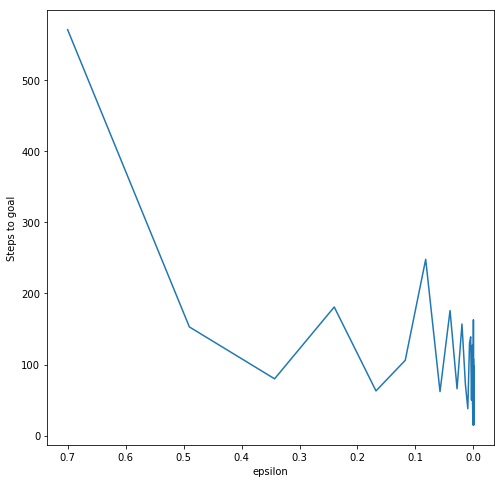

In [289]:
Q, stepsToGoal = trainQ_4disk(100, 0.5, 0.7, validMoves_4disk, makeMove_4disk)

In [290]:
stepsToGoal

array([ 571.,  153.,   80.,  181.,   63.,  106.,  248.,   62.,  176.,
         66.,  157.,   72.,   38.,  130.,  139.,   50.,  127.,   50.,
         28.,  124.,  128.,   58.,   30.,   29.,   94.,   59.,   28.,
         21.,  163.,   47.,   41.,   50.,   17.,  108.,   34.,   20.,
         39.,   63.,   23.,   24.,   24.,   36.,   23.,   50.,   99.,
         16.,   17.,   19.,   19.,   32.,   25.,   15.,   15.,   20.,
         67.,   17.,   17.,   17.,   15.,   15.,   18.,   15.,   15.,
         15.,   35.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,
         15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,
         15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,
         15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.])

In [291]:
path_4disk = testQ_4disk(Q, 20, validMoves_4disk, makeMove_4disk)

In [292]:
print(len(path_4disk))
for s in path_4disk:
    printState_4disk(s)
    print()

16
1    
2    
3    
4    
------

     
2    
3    
4 1  
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
    1
4 3 2
------

     
     
1    
4 3 2
------

     
     
1 2  
4 3  
------

     
  1  
  2  
4 3  
------

     
  1  
  2  
  3 4
------

     
     
  2 1
  3 4
------

     
     
    1
2 3 4
------

     
     
1    
2 3 4
------

     
     
1   3
2   4
------

     
     
    3
2 1 4
------

     
    2
    3
  1 4
------

    1
    2
    3
    4
------



Ahhhh there we go! What if we take fewer turns and instead tweak other values?

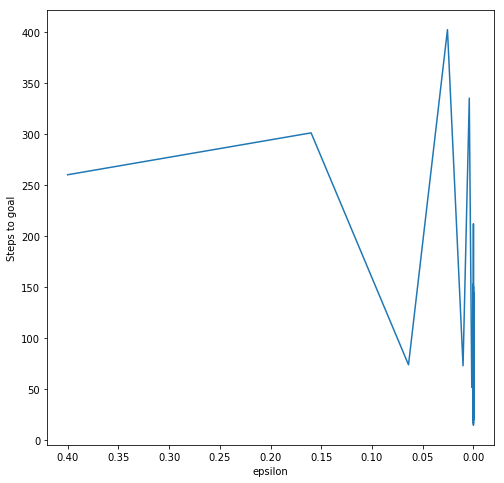

In [293]:
Q, stepsToGoal = trainQ_4disk(50, 0.5, 0.4, validMoves_4disk, makeMove_4disk)

In [294]:
stepsToGoal

array([ 260.,  301.,   74.,  402.,   73.,  335.,   52.,   68.,  153.,
         52.,   64.,  145.,   65.,   34.,  109.,   62.,  212.,   26.,
         52.,  151.,   25.,   57.,  120.,   28.,   83.,   46.,   53.,
         29.,   84.,   29.,   49.,   19.,  112.,   23.,   40.,   34.,
         84.,   20.,   55.,   81.,   45.,   29.,   40.,   17.,   18.,
         15.,   23.,   31.,   21.,   91.])

In [295]:
path_4disk = testQ_4disk(Q, 20, validMoves_4disk, makeMove_4disk)

In [296]:
for s in path_4disk:
    printState_4disk(s)
    print()

1    
2    
3    
4    
------

     
2    
3    
4 1  
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
3    
4 1 2
------



Nope!

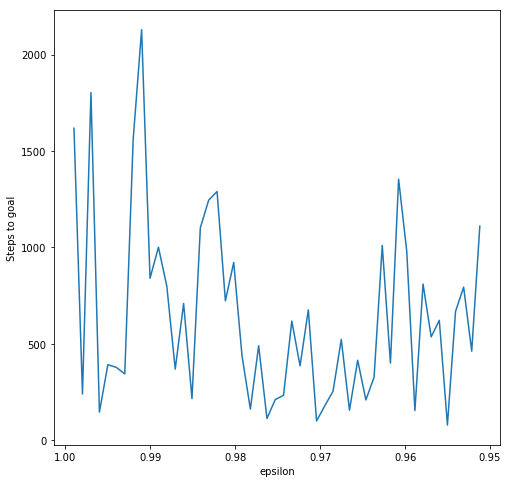

In [297]:
Q, stepsToGoal = trainQ_4disk(50, 0.5, 0.999, validMoves_4disk, makeMove_4disk)

In [298]:
stepsToGoal

array([ 1618.,   240.,  1803.,   146.,   392.,   378.,   344.,  1561.,
        2129.,   840.,  1001.,   798.,   369.,   709.,   216.,  1102.,
        1245.,  1290.,   723.,   922.,   437.,   162.,   490.,   113.,
         211.,   233.,   618.,   386.,   676.,   100.,   179.,   254.,
         523.,   156.,   415.,   209.,   327.,  1010.,   400.,  1354.,
         980.,   154.,   810.,   536.,   622.,    79.,   668.,   794.,
         462.,  1110.])

Ok this was a bit silly, not even close

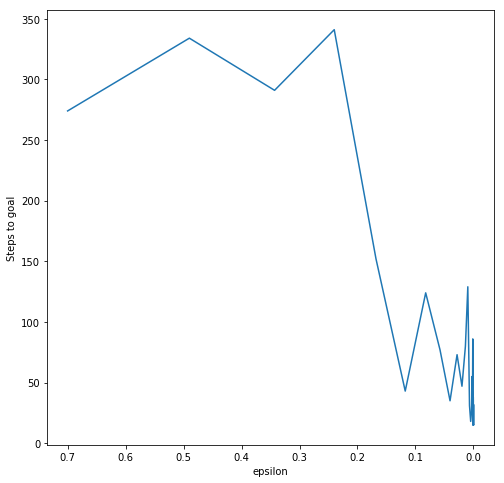

In [299]:
Q, stepsToGoal = trainQ_4disk(50, 0.999, 0.7, validMoves_4disk, makeMove_4disk)

In [300]:
stepsToGoal

array([ 274.,  334.,  291.,  341.,  152.,   43.,  124.,   77.,   35.,
         73.,   47.,   80.,  129.,   31.,   18.,   26.,   55.,   29.,
         86.,   22.,   15.,   20.,   38.,   35.,   15.,   32.,   22.,
         15.,   19.,   26.,   32.,   17.,   15.,   15.,   15.,   15.,
         15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,   15.,
         15.,   15.,   15.,   15.,   15.])

In [301]:
path_4disk = testQ_4disk(Q, 20, validMoves_4disk, makeMove_4disk)

In [302]:
print(len(path_4disk))
for s in path_4disk:
    printState_4disk(s)
    print()

16
1    
2    
3    
4    
------

     
2    
3    
4 1  
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
    1
4 3 2
------

     
     
1    
4 3 2
------

     
     
1 2  
4 3  
------

     
  1  
  2  
4 3  
------

     
  1  
  2  
  3 4
------

     
     
  2 1
  3 4
------

     
     
    1
2 3 4
------

     
     
1    
2 3 4
------

     
     
1   3
2   4
------

     
     
    3
2 1 4
------

     
    2
    3
  1 4
------

    1
    2
    3
    4
------



So, we still get a result and it still takes only 16 steps... but it looks like we can cheat it even more

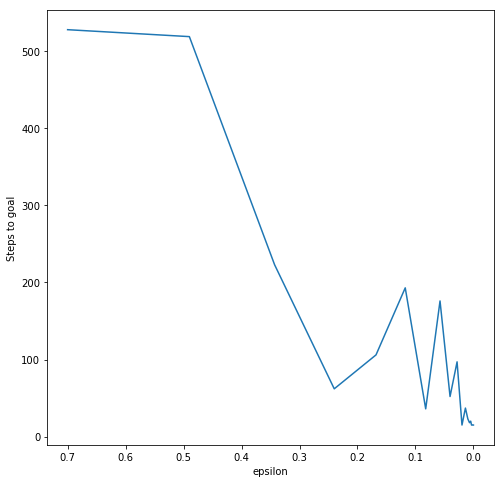

In [303]:
Q, stepsToGoal = trainQ_4disk(30, 0.999, 0.7, validMoves_4disk, makeMove_4disk) # can 30 work?

In [304]:
path_4disk = testQ_4disk(Q, 20, validMoves_4disk, makeMove_4disk)

In [305]:
print(len(path_4disk))
for s in path_4disk:
    printState_4disk(s)
    print()

16
1    
2    
3    
4    
------

     
2    
3    
4 1  
------

     
     
3    
4 1 2
------

     
     
3   1
4   2
------

     
     
    1
4 3 2
------

     
     
1    
4 3 2
------

     
     
1 2  
4 3  
------

     
  1  
  2  
4 3  
------

     
  1  
  2  
  3 4
------

     
     
  2 1
  3 4
------

     
     
    1
2 3 4
------

     
     
1    
2 3 4
------

     
     
1   3
2   4
------

     
     
    3
2 1 4
------

     
    2
    3
  1 4
------

    1
    2
    3
    4
------



Welp, we got there in 30 iterations, but there is one extra step in there! I think 50 is the safest option with a low decay rate like 0.999